# Solving Transient Problems


Let's understand how to use `solve_ivp` and then apply it to our transient conduction problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
#help(solve_ivp)

# Transient, Lumped-Parameter Analysis

**Example**:  Solve the lumped-parameter equation

$$
 C \frac{d \bar{T}}{dt} = - U(t) (\bar{T}-T_{\infty}(t)) + \dot{Q}(t) \, ,  \quad \bar{T}(0) = 95 \, ,
$$

where $C = 10$ is the heat capacity of the lump, $U(t) = 5+5/(1+t)$ is the total heat transfer coefficient, and $\dot{Q}=0$ is the heat-generation rate of the lump.   For now, assume $T_{\infty}(t) = 35$ is constant. The nonlinear $U(t)$ is intended to represent a transfer process that slows with time $U(0) = 10$ and $U(\infty) = 5$.  Realistic?  Not sure, but it makes the problem more interesting!


First, rewrite as 

$$
 \frac{d \bar{T}}{dt} =  \frac{\dot{Q}(t) - U(t) (\bar{T}-T_{\infty}(t))}{C}
$$

Now, implement this derivative as a Python function:

In [3]:
def T_prime(t, T_bar, C, U, Qdot, T_oo):
    return (Qdot(t)-U(t)*(T_bar-T_oo(t)))/C

The time span to consider isn't defined, but we probably want to go out far enough to be visually stable.  Recall, the time constant for such systems is $\tau = C/U$.  That changes here, but $U$ bottoms out at 5, so $\tau$ maxes at 2.  The "5-$\tau$" rule says we'll be very close to the final number (assuming no heat generation!), a rule that is covered in depth in ME 535.  So, that means 10 s or so!

In [4]:
t_initial = 0.0
t_final = 90.0
t_eval = np.linspace(t_initial, t_final, 100) # times at which we want the solution; otherwise, the solver selects!

Define the initial conditions and other problem parameters:

In [5]:
V = .03**2 * np.pi * 0.12
SA = np.pi*(2*.03**2 + 0.06*0.12)

In [6]:
T0 = 35.0 #100.0
C = 1000 * 4220 * V # # 10
U = lambda t: 1000 * (SA)
Qdot = lambda t: 0.0
T_oo = lambda t: 0.0 # 35.0

How should $C$ and $U$ be defined for the case of our hot can in an ice bath?

Now, solve the problem!

In [7]:
sol = solve_ivp(T_prime, [t_initial, t_final], [T0], 
                args=(C, U, Qdot, T_oo),
                t_eval=t_eval)

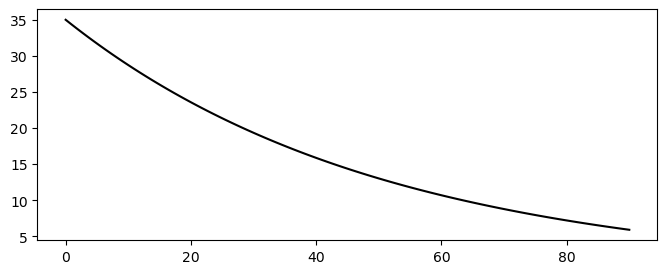

In [8]:
plt.figure(figsize=(8,3))
plt.plot(sol.t, sol.y[0], 'k')
#plt.ylim(30, 105)

**Exercise**: Use Eq. (12) of the notes to "verify" this solution approach.  What do you need to change?

## Spatio-temporal Conduction

Last time, we did this:

$$
 -\nabla k(r,z) \nabla T = \dot{q}'''(r, z) \longrightarrow \mathbf{A}\mathbf{T} = \mathbf{b} \, .
$$

What about 

$$
  \frac{1}{\rho c_p} \frac{\partial T}{\partial t} = \nabla k(r,z) \nabla T + \dot{q}'''(r, z, t) \longrightarrow \quad \large{???} \, .
$$

The basic idea is simple:

$$
   \frac{d\mathbf{T}}{dt} = \rho c_p \left ( -\mathbf {A} + \mathbf{b} \right ) \, ,
$$         

which matches the form needed for `solve_ivp`.

**Caveat**: Dirichlet conditions require special treatment!  

Example. 3 axial cells with no radial dependence:

$$
\dot{\mathbf T}=\frac{1}{\rho c_p}\left(\mathbf b-\mathbf A\,\mathbf T\right),
\qquad
\mathbf T=\begin{bmatrix}T_1\\[2pt]T_2\\[2pt]T_3\end{bmatrix},
$$

$$
\mathbf A=
\begin{bmatrix}
1 & 0 & 0\\[2pt]
- D_S^{(2)} & D_S^{(2)}+D_N^{(2)} & - D_N^{(2)}\\[2pt]
0 & - D_S^{(3)} & D_S^{(3)} + D_N^{(3)}\,\alpha_N
\end{bmatrix},
\qquad
\mathbf b=
\begin{bmatrix}
T_b\\[2pt]
q^{\prime\prime\prime}_2\\[2pt]
q^{\prime\prime\prime}_3 + D_N^{(3)}\,\gamma_N
\end{bmatrix}.
$$

$$
\begin{aligned}
& D_S^{(2)}=\frac{k_{3/2}}{\Delta z^2}, \quad
  D_N^{(2)}=\frac{k_{5/2}}{\Delta z^2}, \quad
  D_S^{(3)}=D_N^{(2)}, \quad
  D_N^{(3)}=\frac{k_{3}}{\Delta z^2}, \\[4pt]
& k_{j\pm\frac12}=\frac{2\,k_j\,k_{j\pm1}}{k_j+k_{j\pm1}}
\ \text{(harmonic mean)}, \qquad
\beta_N=\frac{h\,\Delta z}{k_3}, \quad
\alpha_N=\frac{1-\beta_N}{1+\beta_N}, \quad
\gamma_N=\frac{2\beta_N}{1+\beta_N}\,T_\infty .
\end{aligned}
$$


$$
\begin{aligned}
\dot T_1 &= \frac{T_b - T_1}{\rho c_p}
\quad\text{erroneous "relaxation" from the Dirichlet identity row},\\
\dot T_2 &= \frac{q^{\prime\prime\prime}_2
            - (D_S^{(2)}+D_N^{(2)})\,T_2
            + D_S^{(2)}\,T_1
            + D_N^{(2)}\,T_3}{\rho c_p},\\[4pt]
\dot T_3 &= \frac{q^{\prime\prime\prime}_3
            + D_N^{(3)}\,\gamma_N
            + D_S^{(3)}\,T_2
            - \big(D_S^{(3)} + D_N^{(3)}\,\alpha_N\big)\,T_3}{\rho c_p}.
\end{aligned}
$$

$$
\begin{aligned}
& D_S^{(2)}=\frac{k_{3/2}}{\Delta z^2},\quad
  D_N^{(2)}=\frac{k_{5/2}}{\Delta z^2},\quad
  D_S^{(3)}=D_N^{(2)},\quad
  D_N^{(3)}=\frac{k_3}{\Delta z^2},\\[4pt]
& k_{j\pm\frac12}=\frac{2k_j k_{j\pm1}}{k_j+k_{j\pm1}},\qquad
  \beta_N=\frac{h\,\Delta z}{k_3},\quad
  \alpha_N=\frac{1-\beta_N}{1+\beta_N},\quad
  \gamma_N=\frac{2\beta_N}{1+\beta_N}\,T_\infty.
\end{aligned}
$$

In [9]:
from starter_code import construct_system

In [19]:
N_r = 10
N_z = 40

r_edge = np.linspace(0, 0.03, N_r+1)
z_edge = np.linspace(0, 0.12, N_z+1)

r_center = r_edge[1:]-r_edge[0]/2
z_center = z_edge[1:]-z_edge[0]/2

In [20]:
kfun = lambda r, z : 0.1
qppp = lambda r, z : 0

In [21]:
BC_z = ('dirichlet', 10)
BC_r_top = ('dirichlet', 10)
BC_r_bottom = ('dirichlet', 10)

In [22]:
A, b = construct_system(r_center, z_center, kfun, qppp,
                        BC_z, BC_r_top, BC_r_bottom)

In [23]:
def T_prime(t, T, A, b, rho, c_p):
    #print(A, T)
    return (b - A@T)*rho*c_p

In [24]:
rho = 1
c_p = 4.0

In [37]:
T0 = 0*np.ones(A.shape[0])

In [38]:
A.shape

t_initial = 0.0
t_final = 10.0
t_eval = np.linspace(t_initial, t_final, 50) # times at which we want the solution; otherwise, the solver selects!

In [39]:
sol = solve_ivp(T_prime, [t_initial, t_final], T0, 
                args=(A, b, rho, c_p),
                t_eval=t_eval)

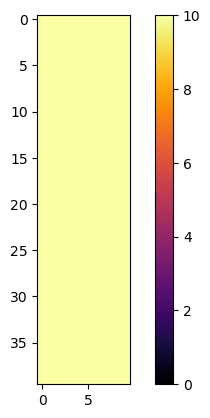

In [50]:
i = 49
plt.imshow(sol.y[:,i].reshape((N_z, N_r)), cmap="inferno",vmin=0,vmax=np.max(sol.y)); cbar = plt.colorbar();

In [ ]:
D = 0.06 # {m}

mu = 17.916e-4 # {Pa*s}
k = 555.75 / 1000 # {W/m*K}
rho = 1000 # ~{kg/m^3}
v = np.pi*D # {m/s}
Cp = 4.22 * 1000 # {J/kg*K}

Re = rho * v * D / mu
Pr = Cp * mu / k
#Nu = 0.664 * Re**0.5 * Pr**(1/3)
Nu = 0.133 * Re**(2/3) * Pr**(1/3)
HTC = Nu*k/D

HTC,Re

In [ ]:
T_bar_sol = [sol.y[:][i]/len(sol.y[:][i]) for i in range(len(sol.y))][0]